# **MDI 341 : Travaux Pratiques – Chaînes de Markov-HMMs**
***Thomas KOCH***

Ce TP se déroule en deux parties. La première partie concerne les chaînes de Markov et est à
finir absolument. Les plus rapides d’entre vous pourront aborder la deuxième partie qui traite
des HMMs. Les ressources (matrices de transition, modèles HMMs…) sont sur :
- Partie I : http://perso.telecom-paristech.fr/~lauli/TP_Chaine_Markov/
- Partie II : http://perso.telecom-paristech.fr/~lauli/TPHMM_MDI343/

## **Partie 1**
## **I.1 Fonctions dont vous pouvez avoir besoin**
`cumsum` : fonction de répartition : somme cumulative des termes du vecteur $p$
```python
import numpy as np
np.cumsum(p)
```

`random` : génère un nombre aléatoire entre $[0 1]$ selon une loi uniforme.
```python
import numpy as np
np.random.random()
```

`load` : chargement d’un fichier
```python
filename_A = 'bigramenglish.txt'
np.loadtxt(filename_A)
```

Création du dictionnaire clé-valeur associant états et caractères :
```python
dic = {'0':' ', '1':'a', '2':'b', '3':'c', '4':'d', '5':'e', '6':'f', '7':'g',
       '8':'h', '9':'i', '10':'j', '11':'k', '12':'l', '13':'m', '14':'n',
       '15':'o', '16':'p', '17':'q', '18':'r' , '19':'s', '20':'t', '21':'u',
       '22':'v', '23':'w', '24':'x' , '25':'y', '26':'z', '27':' '}
```

Inverser le dictionnaire (les valeurs deviennent les clés et réciproquement)
```python
dic_inv = {v: k for k, v in dic.items()}
```

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# matrix display precision
np.set_printoptions(suppress=True, precision=3)

In [2]:
plt.style.available
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html

['tableau-colorblind10',
 'seaborn-bright',
 'seaborn-poster',
 'ggplot',
 'seaborn',
 'seaborn-muted',
 'seaborn-dark-palette',
 'fast',
 'seaborn-darkgrid',
 'seaborn-talk',
 'Solarize_Light2',
 'classic',
 'fivethirtyeight',
 'bmh',
 'seaborn-pastel',
 'seaborn-deep',
 'seaborn-notebook',
 'seaborn-ticks',
 'seaborn-whitegrid',
 'seaborn-dark',
 'seaborn-paper',
 'grayscale',
 'dark_background',
 '_classic_test',
 'seaborn-white',
 'seaborn-colorblind']

## **I.2 Chaîne de Markov**

On veut générer des mots dans une langue donnée en modélisant la formation de ces mots par une chaîne de Markov. Les 28 états du modèle correspondent aux 26 lettres de l’alphabet auxquelles on ajoute un état "espace initial" (état 1) et un état "espace final" (état 28) qui sert à terminer les mots.

La correspondance entre la valeur numérique d’un état et un caractère est la suivante : l’état 1
correspond à un espace (avant le début d’un mot) et l’état 28 à celui d’un espace en fin de mot. Les états 2 à 27 correspondent aux caractères de *a* à *z*. On pourra utiliser une structure de
dictionnaire en python pour faire cette correspondance.

On utilisera une chaîne de Markov ergodique entre les 26 états correspondants aux lettres de l’alphabet.

### **I.2.a Matrice de transitions**

***'bigramenglish.txt'*** contient la matrice des transitions pour l’anglais (bigrams) entre deux
symboles (caractères ou espaces). Le terme générique $(i,j)$ de la matrice de transition
correspond à la probabilité de transiter vers l’état $j$ à partir de l’état $i$.

A quelles probabilités correspond la première ligne de la matrice de transition ? et celles de la
dernière ligne ?

In [3]:
filename_A = "bigramenglish.txt"
bigram_eng = pd.read_csv(filename_A, sep='   ', header=None, engine='python')

In [4]:
bigram_eng.shape

(28, 28)

In [5]:
bigram_eng.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.025680,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000
1,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.094822,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478
2,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.047390,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108
3,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.052501,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535
4,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.018984,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844


> La première ligne de la matrice de transition correspond aux **probabilités de transitions en partant de l'état initial**.

> La dernière ligne de la matrice de transition correspond aux **probabilités de transitions en partant de l'état final**. Cet état signale la fin du mot.

> En résumé, la matrice A ressemble à : 
  
|                  | espace_debut | a | b | ... | z | espace_fin |
|------------------|--------------|---|---|-----|---|------------|
| **espace_debut** |     ...      |...|...| ... |...|   ...      |
| **a**            |     ...      |...|...| ... |...|   ...      |
| **b**            |     ...      |...|...| ... |...|   ...      |
| **...**          |     ...      |...|...| ... |...|   ...      |
| **z**            |     ...      |...|...| ... |...|   ...      |
| **espace_fin**   |      0       | 0 | 0 | ... | 0 |    1       |

> La dernière colonne correspond donc aux **probabilités que l'espace de fin arrive après la lettre de la ligne considérée**.

Pour chaque lettre de l’alphabet, indiquer la transition la plus fréquente depuis cette lettre. 

In [6]:
dic = {0:' ', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g',
       8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
       15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u',
       22:'v', 23:'w', 24:'x' , 25:'y', 26:'z', 27:' '}

In [7]:
transition_letters = [dic[x] for x in bigram_eng.idxmax(axis=1)]

for i in range(0,28):
    print("From state '{}', the most frequent transition is state '{}'".format(dic[i],transition_letters[i]))

From state ' ', the most frequent transition is state 't'
From state 'a', the most frequent transition is state 'n'
From state 'b', the most frequent transition is state 'e'
From state 'c', the most frequent transition is state 'o'
From state 'd', the most frequent transition is state ' '
From state 'e', the most frequent transition is state ' '
From state 'f', the most frequent transition is state ' '
From state 'g', the most frequent transition is state ' '
From state 'h', the most frequent transition is state 'e'
From state 'i', the most frequent transition is state 'n'
From state 'j', the most frequent transition is state 'o'
From state 'k', the most frequent transition is state ' '
From state 'l', the most frequent transition is state 'e'
From state 'm', the most frequent transition is state 'e'
From state 'n', the most frequent transition is state ' '
From state 'o', the most frequent transition is state 'n'
From state 'p', the most frequent transition is state 'e'
From state 'q'

> Les transitions les plus fréquentes depuis chaque état du dictionnaire se trouvent donc ci-dessus. On peut noter que :
>- **les mots anglais ont donc une forte probabilité de commencer par la lettre *t***
>- **les lettre *d, e, f, g, k, n, s et y* sont souvent employées en fin de mot**.

### **I.2.b Générer un mot**

On veut générer un mot à partir de l’état initial 1 (espace de début de mot).

Ecrire une fonction `etat_suivant` qui génère un état (à $t+1$) à partir de l’état courant (à $t$) à l’aide de la matrice de transitions et de la fonction de répartition. 

In [8]:
def etat_suivant(dic, bigram, state) :
    
    unif = np.random.random()
    #print("unif = {}\n".format(unif))
    
    line_A = bigram.iloc[state]
    
    cum_sum = np.cumsum(line_A)
    #print("cum_sum : \n{}\n".format(cum_sum))
    
    next_state = np.where(cum_sum > unif)[0][0]
    
    #print("=======================\nGenerated state is '{}'".format(next_state))
    
    return next_state

In [11]:
etat_suivant(dic=dic, bigram=bigram_eng, state=0)

unif = 0.7235345996109626

cum_sum : 
0     0.000000
1     0.112687
2     0.156296
3     0.201751
4     0.234655
5     0.256750
6     0.298513
7     0.314069
8     0.378507
9     0.447427
10    0.451065
11    0.455284
12    0.478749
13    0.518509
14    0.541341
15    0.611685
16    0.642744
17    0.644168
18    0.669848
19    0.736764
20    0.901287
21    0.911675
22    0.918741
23    0.989243
24    0.989348
25    0.999947
26    1.000000
27    1.000000
Name: 0, dtype: float64

Generated state is '19'


19

Afficher sur un graphique la fonction de répartition pour une ligne de la matrice de transition et expliquer son rôle pour la génération de l’état à $t+1$.

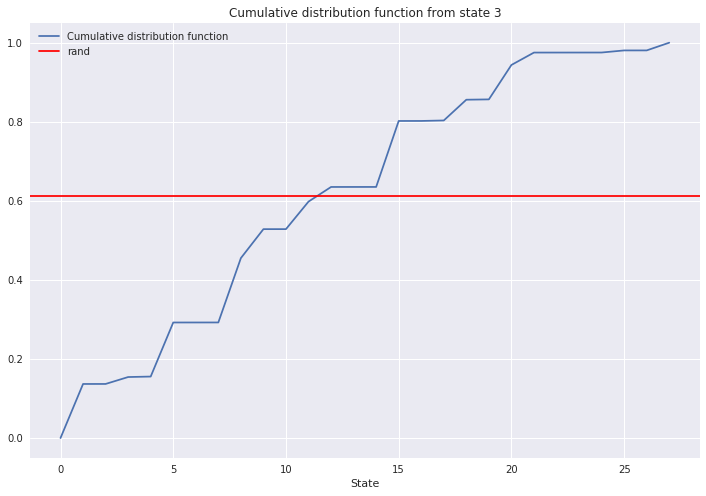

In [9]:
unif = np.random.random()
cum_sum = np.cumsum(bigram_eng.iloc[3])

plt.figure(figsize=(12,8))
plt.title("Cumulative distribution function from state 3")
plt.plot(cum_sum, label='Cumulative distribution function')
plt.axhline(unif, c='red', label='rand')
plt.xlabel('State')
plt.ylabel('')
plt.legend()
plt.show()

> La fonction de distribution cumulative nous **permet de trouver l'état suivant à partir d'une variable aléatoire tirée selon une loi uniforme**.

Utiliser cette fonction pour écrire la fonction `genere_state_seq` qui génère une séquence
d’états jusqu’à aboutir à l’état final (27). 

In [10]:
def generate_state_seq(dic, bigram) :
    
    state = 0
    seq = []
    
    while state < 27 :
        state = etat_suivant(dic, bigram, state)
        seq.append(state)

    return seq

In [14]:
generate_state_seq(dic, bigram_eng)

[1, 18, 19, 20, 8, 5, 27]

Ecrire une fonction `display_seq` qui transforme une séquence d’états en séquence de caractères, à l’aide d’un dictionnaire. 

Utiliser ces fonctions pour générer des mots et donner des exemples de mots générés.

In [15]:
def display_seq(dic, bigram) :
    
    sequence = generate_state_seq(dic, bigram)
    len_seq = len(sequence)

    word = []
    for i in range(len_seq):
        word.append(dic[sequence[i]])
    
    return ''.join(word)

In [16]:
display_seq(dic, bigram_eng)

'pexpen '

In [17]:
for i in range(30):
    print(display_seq(dic, bigram_eng))

fofof 
fthe 
in 
am 
ghon 
rgreeasu 
thu 
ithopthit 
t 
ndosoffe 
lf 
cin 
made 
ustrocerencredllather 
tinclfensprealld 
fo 
as 
t 
cheinival 
is 
ade 
tont 
d 
isssetsontwis 
wictise 
wkndonthe 
my 
as 
tanof 
h 


> Les mots générés n'existent pas réellement dans leur grande majorité.

### **I.2.c Générer une phrase**
On veut générer une suite de mots (phrase). 

Créer un état final de phrase (**état 29**, correspondant au caractère ".") dont la probabilité de transition vers cet état depuis un état final de mot est $0.1$. 

> Nous devons donc obtenir une matrice de la forme suivante :

|                  | espace_debut | a | b | ... | z | espace_fin | . |
|------------------|--------------|---|---|-----|---|------------|---|
| **espace_debut** |     ...      |...|...| ... |...|   ...      | 0 |
| **a**            |     ...      |...|...| ... |...|   ...      | 0 |
| **b**            |     ...      |...|...| ... |...|   ...      | 0 |
| **...**          |     ...      |...|...| ... |...|   ...      | 0 |
| **z**            |     ...      |...|...| ... |...|   ...      | 0 |
| **espace_fin**   |     0.9      | 0 | 0 | ... | 0 |    0       |0.1|
| **.**            |      0       | 0 | 0 | ... | 0 |    0       | 1 |

Ecrire une fonction `modify_mat_dic` qui modifie la matrice de transition et le dictionnaire en conséquence. 

In [18]:
def modify_mat_dic(bigram, dic) :
    
    #-------------- Matrix Modification ---------------
    # Append new row at the end of the DataFrame
    new_row = pd.Series(np.zeros(28))
    bigram = bigram.append(new_row, ignore_index=True, sort=False)
    
    # Append new column at the end of the DataFrame
    new_col = pd.Series(np.zeros(29))
    bigram = pd.concat([bigram, new_col], axis=1, ignore_index=True)
    
    # Modify values to have the expected matrix
    bigram.iloc[27, 0] = 0.9
    bigram.iloc[27, 27] = 0.0
    bigram.iloc[27, 28] = 0.1
    bigram.iloc[28, 28] = 1.0
    
    #-------------- Dictionary Modification ---------------
    # Adding a new key value pair in the dictionary
    dic2 = dict(dic)
    dic2.update({28 : '.'})
    
    return bigram, dic2 

In [19]:
bigram_eng2, dic2  = modify_mat_dic(bigram_eng, dic)

In [20]:
dic2

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: ' ',
 28: '.'}

In [21]:
bigram_eng2

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000,0.0
1,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478,0.0
2,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108,0.0
3,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535,0.0
4,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844,0.0
5,0.0,0.045607,0.003171,0.018653,0.078064,0.027980,0.009606,0.007181,0.001679,0.016042,...,0.072095,0.023317,0.000466,0.016601,0.008860,0.008394,0.015109,0.000093,0.360474,0.0
6,0.0,0.066869,0.000047,0.000047,0.000047,0.074351,0.033668,0.000047,0.000047,0.077625,...,0.001870,0.046294,0.032733,0.000047,0.000047,0.000047,0.003273,0.000047,0.396540,0.0
7,0.0,0.065942,0.000611,0.000061,0.002442,0.128221,0.000061,0.012212,0.135548,0.062889,...,0.026255,0.006106,0.021370,0.000061,0.000611,0.000061,0.003053,0.000061,0.315667,0.0
8,0.0,0.141975,0.000772,0.000019,0.000019,0.469715,0.000579,0.000019,0.000386,0.140239,...,0.001736,0.024498,0.019097,0.000019,0.001157,0.000019,0.002122,0.000019,0.103009,0.0
9,0.0,0.020688,0.010501,0.076954,0.038085,0.033697,0.023666,0.034010,0.000016,0.000313,...,0.127578,0.117547,0.000940,0.032600,0.000016,0.001097,0.000016,0.006269,0.024607,0.0


Donner des exemples de phrases générées.

In [22]:
def generate_state_seq2(dic, bigram) :
    
    state = 0
    seq = []
    
    while state < 28 :
        state = etat_suivant(dic, bigram, state)
        seq.append(state)

    return seq

In [23]:
def display_seq2(dic, bigram) :
    
    sequence = generate_state_seq2(dic, bigram)
    len_seq = len(sequence)

    word = []
    for i in range(len_seq):
        word.append(dic[sequence[i]])
    
    return ''.join(word)

In [24]:
for i in range(20):
    print()
    print(display_seq2(dic2, bigram_eng2))


wond  onimiches  llontang  as  d  aranofaf  joroumon  lfint  ig  aconowhougre  fr  blee  t .

h  ry  stes  d  thint .

tem  an  iless  cethe  anoma  opodetudengouisureintlais  acens  wesotill  s  e  jouncimonge  out  t  ignd  t  wfrr  d  anth .

asthere  thomys  oowomas .

satus  ot  andarean  fely  aw  foubis  h  ty  y .

pes  abes  the  ied  he  o  wealensthr  f  winthas  cllet  ees  s  f  funf  ied  on  svag  whof  hay .

s .

chtad .

on  hernis  se  s  tti .

reast .

tore  lldouppameawa  t  ong .

ntollirathe  owa  wor  pew .

s  rdoe  ondinely  itsharas  thilyol  aite  sevee  thatictht  he  ofoppalick  awind .

san  ached  y  se  m  thowe  f  nd  s  ins  ared  t  f  t  alat  thig .

prir  heat  iollasiedurowe  tekesheerend  n  tis  mince  ofom .

inthat  ofe .

bled  thavim  a  llie .

tete  rorechele  fontomeathin .

s  tttweera .

cepros  a  ut  abere  win  rerngr  thild .


> Globalement nous arrivons bien à générer des phrases avec cette nouvelle matrice. Toutefois, difficile d'interpréter ce que nous générons.

## **I.3. Reconnaissance de la langue**

Charger la matrice des transitions entre caractères pour le français. 

In [25]:
filename_B = "bigramfrancais.txt"
bigram_fr = pd.read_csv(filename_B, sep='   ', header=None, engine='python')

In [26]:
bigram_fr.shape

(28, 28)

In [27]:
bigram_fr2, _ = modify_mat_dic(bigram_fr, dic)

In [28]:
bigram_fr2

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.076217,0.011726,0.070354,0.206175,0.067422,0.021497,0.010748,0.000977,0.019543,...,0.060582,0.013680,0.034200,0.006840,0.000098,0.000098,0.000098,0.000977,0.000000,0.0
1,0.0,0.000341,0.003414,0.023899,0.003414,0.000341,0.010242,0.013657,0.000341,0.058040,...,0.081939,0.119495,0.133151,0.020485,0.000341,0.000341,0.000341,0.000341,0.157050,0.0
2,0.0,0.030992,0.001033,0.001033,0.001033,0.020661,0.001033,0.001033,0.001033,0.289256,...,0.010331,0.001033,0.185950,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033,0.0
3,0.0,0.040241,0.000402,0.008048,0.008048,0.301811,0.000402,0.000402,0.060362,0.209256,...,0.000402,0.040241,0.040241,0.000402,0.000402,0.000402,0.000402,0.000402,0.032193,0.0
4,0.0,0.036174,0.000402,0.000402,0.000402,0.546624,0.004019,0.000402,0.000402,0.124598,...,0.008039,0.000402,0.056270,0.000402,0.000402,0.000402,0.000402,0.000402,0.080386,0.0
5,0.0,0.001117,0.029034,0.023451,0.005583,0.012284,0.010050,0.004467,0.000112,0.003350,...,0.173088,0.045784,0.032384,0.006700,0.000112,0.008934,0.000112,0.001117,0.337242,0.0
6,0.0,0.088496,0.001475,0.001475,0.001475,0.176991,0.088496,0.001475,0.001475,0.265487,...,0.044248,0.014749,0.029499,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.0
7,0.0,0.051348,0.001284,0.001284,0.001284,0.115533,0.001284,0.001284,0.001284,0.462131,...,0.001284,0.001284,0.064185,0.001284,0.001284,0.001284,0.001284,0.001284,0.012837,0.0
8,0.0,0.218579,0.005464,0.005464,0.005464,0.437158,0.005464,0.005464,0.005464,0.163934,...,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.054645,0.0
9,0.0,0.065735,0.092440,0.145850,0.004108,0.112983,0.028759,0.014380,0.000205,0.000205,...,0.110929,0.071898,0.002054,0.018488,0.000205,0.000205,0.000205,0.000205,0.030813,0.0


Ecrire une fonction `calc_vraisemblance` qui calcule la vraisemblance du modèle français pour une phrase donnée en multipliant les probabilités de transition. 

Pour tenir compte de toutes les transitions (notamment celles entre espaces de fin et de début de mots et vers la fin de phrase) on pourra transformer une séquence ***« mot1 mot2.»*** par la séquence ***« -mot1+-mot2+.»***, les signes ***-*** , ***+*** et ***.*** représentant l’état initial de mot, l’état final de mot et l’état final de phrase, respectivement.

In [29]:
dic3 = {0:'-', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g',
       8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
       15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u',
       22:'v', 23:'w', 24:'x' , 25:'y', 26:'z', 27:'+', 28:'.'}

In [30]:
dic3

{0: '-',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: '+',
 28: '.'}

In [47]:
def calc_vraisemblance(dic, bi_eng, bi_fr, seq) :
    
    key_0 = 0
    
    # initiate likelihood value
    likelihood_eng = 1
    likelihood_fr = 1
    
    for letter in seq : 
        key_1 = [key for key, val in dic.items() if val == letter][0]
        
        likelihood_eng *= bi_eng.iloc[key_0, key_1]
        likelihood_fr *= bi_fr.iloc[key_0, key_1]
        
        key_0 = [key for key, val in dic.items() if val == letter][0]
    
    if likelihood_eng > likelihood_fr :
        print("La séquence testée est en anglais avec une vraisemblance de {}".format(likelihood_eng))
        print("La vraisemblance pour la langue française était donc plus faible : {}".format(likelihood_fr))
    else : 
        print("La séquence testée est en français avec une vraisemblance de {}".format(likelihood_fr))
        print("La vraisemblance pour la langue anglaise était donc plus faible : {}".format(likelihood_eng))

    
    return likelihood_eng, likelihood_fr

In [34]:
def transform_sentence(seq):
    
    words = seq.split()
    len_list = len(words)
    new_list = []
    i = 1
    
    for w in words:
        
        if i == 1:
            #new_list.append('-')
            new_list.append(w)
            new_list.append('+-')
            
        elif i != len_list:
            new_list.append(w)
            new_list.append('+-')
            
        else:
            fw = w.split('.')
            new_list.append(fw[0])
            new_list.append('+.')
            
        i = i + 1
    return ''.join(new_list)

In [35]:
transform_sentence('to be or not to be')

'to+-be+-or+-not+-to+-be+.'

Calculer la vraisemblance des modèles français et anglais pour la phrase ***« to be or not to be »***.

De même calculer la vraisemblance des modèles français et anglais pour la phrase ***« etre ou ne
pas etre »***.

In [48]:
calc_vraisemblance(dic3, bigram_eng2, bigram_fr2, transform_sentence('to be or not to be'))

La séquence testée est en anglais avec une vraisemblance de 8.112892227809416e-20
La vraisemblance pour la langue française était donc plus faible : 5.960208101868643e-30


(8.112892227809416e-20, 5.960208101868643e-30)

In [49]:
calc_vraisemblance(dic3, bigram_eng2, bigram_fr2, transform_sentence('etre ou ne pas etre'))

La séquence testée est en français avec une vraisemblance de 1.1457068872347888e-19
La vraisemblance pour la langue anglaise était donc plus faible : 4.462288711775254e-24


(4.462288711775254e-24, 1.1457068872347888e-19)

## **Partie 2**
## **II. 1. Introduction**

L’objectif de cette partie est de générer des séquences d’observations suivant un modèle de
Markov Caché donné, puis de calculer la vraisemblance d’une séquence d’observations suivant un modèle de Markov Caché donné.

Le modèle de Markov est de type discret. Les classes de caractères (classes 0, 1, 7) sont
modélisées chacune par un modèle à $Q = 5$ états de type gauche-droite. Les **états 1 et 5**
correspondent à des **colonnes de pixels de type fond de l’image (niveau 0)**. Les états **2, 3 et 4** correspondent au **début, milieu et fin du caractère** respectivement. Les transitions entre états sont indiquées dans la matrice de transitions $A$ de taille $Q\times Q$. Les vecteurs $π$ sont tous égaux à $π = (1 0 0 0 0)$. Les séquences d’états commencent donc toujours par l’état $q_1 = 1$. 

Les séquences d’observations sont discrètes et issues d’images de chiffres de la base MNIST.
Les séquences d’observations consistent en séquences d’index (symboles) des éléments du
dictionnaire. Ce dictionnaire est stocké sous forme matricielle (matrice $v$) dans le fichier
`matrice_symboles`. L’élément numéro $i$ d’une séquence d’observations correspond au symbole $i$ et donc à la colonne $i$ de la matrice $v$. Un symbole correspond à une configuration de colonne de 5 pixels (binaires : noir/blanc). Il y a $2^5 = 32$ configurations, et donc symboles possibles.

Une séquence d’observations correspondant à l’image simplifiée de la fig. 1 est :

$$
[1\ 1\ 1\ 1\ 1\ 1\ 14\ 23\ 23\ 27\ 18\ 18\ 18\ 12\ 12\ 12\ 12\ 12\ 12\ 12\ 23\ 23\ 23\ 14\ 4\ 1\ 1\ 1]
$$

La concaténation des éléments du dictionnaire correspondant aux index de la séquence d’observations peut être visualisée sous forme d’image en remplaçant chaque index par le vecteur de pixels correspondant dans le dictionnaire (Fig. 2 du sujet). 


## **II. 2. Génération de séquences d’observations**

Les matrices `A0.txt`, `B0.txt`, `vect_pi0.txt` contiennent les matrices $A$, $B$, et le vecteur $π$ correspondant au modèle de Markov caché du chiffre 0. Le fichier `matrice_symboles.txt`
contient le dictionnaire. Charger ces fichiers depuis le site pédagogique. 

Le dictionnaire de symboles se trouve dans la matrice $v$ qui se charge en utilisant :

```python
import numpy as np
filename = 'matrice_symboles.txt'
v = np.loadtxt(filename)
```

In [80]:
path = 'data_txt_compact/'
A0 = np.loadtxt(path + 'A0.txt') # Transitions entre états
B0 = np.loadtxt(path + 'B0.txt') # Probabilité des observations dans chaque état caché
Pi0 = np.loadtxt(path + 'vect_pi0.txt') # Probabilité état inital
v = np.loadtxt(path + 'matrice_symboles.txt') # Dictionnaire des motifs

### **II. 2.1 Matrices creuses**
A quoi correspondent les zéros de la matrice $B$ ? et ceux de la matrice $A$ et du vecteur $π$ ?

In [81]:
print('shape(B0) :',np.shape(B0))
print('shape(A0) :',np.shape(A0))
print('shape(Pi0) :',np.shape(Pi0))

shape(B0) : (32, 5)
shape(A0) : (5, 5)
shape(Pi0) : (5,)


In [82]:
print("La matrice A est de la forme : \n")
A0

La matrice A est de la forme : 



array([[ 0.842,  0.158, -0.   , -0.   , -0.   ],
       [-0.   ,  0.789,  0.211, -0.   , -0.   ],
       [-0.   , -0.   ,  0.863,  0.137, -0.   ],
       [-0.   , -0.   , -0.   ,  0.792,  0.208],
       [-0.   , -0.   , -0.   , -0.   ,  1.   ]])

In [83]:
print("La matrice B est de la forme : \n")
B0

La matrice B est de la forme : 



array([[ 1.   , -0.   , -0.   , -0.   ,  1.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.018, -0.   ],
       [-0.   ,  0.078,  0.   ,  0.129, -0.   ],
       [-0.   ,  0.012,  0.017,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.003,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.024,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.018,  0.   ,  0.163, -0.   ],
       [-0.   ,  0.   ,  0.317,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.215,  0.   ,  0.049, -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.019, -0.   ],
       [-0.   ,  0.   ,  0.454,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   ,  0.002, -0.   ],
       [-0.   ,  0. 

In [84]:
print("Le vecteur Pi est de la forme : \n")
Pi0

Le vecteur Pi est de la forme : 



array([1., 0., 0., 0., 0.])

> Les zéros de la matrice `B0` correspondent aux **motifs impossibles dans l'état correspondant à la colonne considérée**.

> Les zéros de la matrice `A0` correspondent aux **transitions impossibles entre l'état de la ligne et celui de la considérées**.

> Les zéros du vecteur $\pi$ correspondent aux **états initiaux impossibles**. Seul le premier état est donc possible avec ce vecteur.

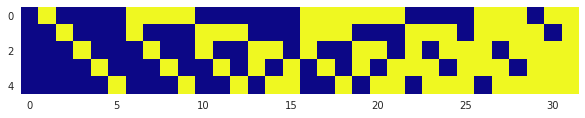

In [148]:
plt.figure(figsize=(10,8))
plt.imshow(v, cmap='plasma')
plt.grid(False)
plt.show()

### **II.2.2 Fonction de transition**
Ecrire une fonction `etat_suivant` qui génère un état $q_{t+1}$ (à $\textit{t+1}$) à partir de l’état courant $q_t$ (à $t$) à l’aide de la matrice de transitions et de la fonction de répartition `cumsum`. 

In [109]:
def etat_suivant_p2(transition_matrix, current_state) :
    
    unif = np.random.random()
    #print("unif = {}\n".format(unif))
    
    line_A = transition_matrix[current_state-1,:]
    
    cum_sum = np.cumsum(line_A)
    #print("cum_sum : \n{}\n".format(cum_sum))
    
    next_state = sum(cum_sum < unif) + 1
    
    #print("=======================\nGenerated state is '{}'".format(next_state))
    
    return next_state

Afficher la fonction de répartition pour une ligne de la matrice de transition et expliquer son rôle pour la génération de l’état à $\textit{t+1}$.

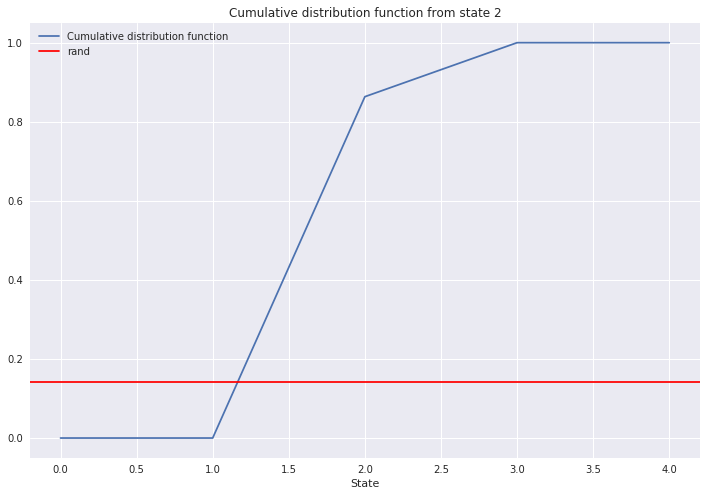

In [92]:
unif = np.random.random()
cum_sum = np.cumsum(A0[2,:])

plt.figure(figsize=(12,8))
plt.title("Cumulative distribution function from state 2")
plt.plot(cum_sum, label='Cumulative distribution function')
plt.axhline(unif, c='red', label='rand')
plt.xlabel('State')
plt.ylabel('')
plt.legend()
plt.show()

> La fonction de répartition permet donc de générer l'état $\textit{t+1}$ à partir de l'état $t$ grâce à un nombre tiré aléatoirement selon une loi uniforme. On utilise ici l'inversion de la fonction de répartition.

### **II.2.3 Généreration d'une séquence d’observations** 
Générer une qéquence d'observation suivant le modèle de Markov Caché du chiffre $0$.
On commencera par générer une séquence d’états suivant ce modèle à l’aide de la fonction
`etat_suivant_p2`. Puis on générera la séquence d’observations par le même procédé. 

In [112]:
def generate_state_seq_obs(trans_matrix, obs_matrix) :
    
    # On initialise la séquence d'état
    state_seq = [1]
    # On initialise la séquence d'observations
    obs_seq = [etat_suivant_p2(obs_matrix.T, 1)]
    # On détermine l'état final
    terminal_state = trans_matrix.shape[0]
    
    # On génère nos séquences
    while state_seq[-1] < terminal_state:
        
        state_seq.append(etat_suivant_p2(trans_matrix, state_seq[-1]))
        obs_seq.append(etat_suivant_p2(trans_matrix.T, state_seq[-1]))
    
    return state_seq, obs_seq

In [126]:
# Génération de deux séquences et affichage des résultats
state_seq, obs_seq = generate_state_seq_obs(A0, B0)

print("La séquence des états cachés générées est :")
print(state_seq)
print("La séquence des observations générées est :")
print(obs_seq)

La séquence des états cachés générées est :
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5]
La séquence des observations générées est :
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 6, 4, 5]


### **II.2.4 Visualisation des résultats**
Visualiser le résultat sous forme d’image. 

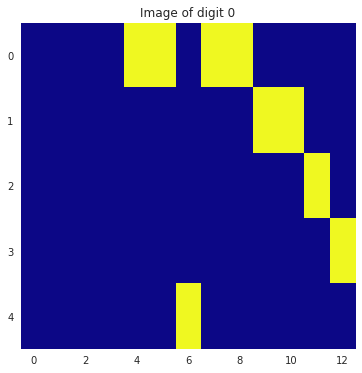

In [139]:
# visualization of image generated in previous question
image = np.stack([v[:,symbol-1] for symbol in obs_seq], axis=0).T
plt.figure(figsize=(6,6))
plt.imshow(image, interpolation='none', aspect='auto', cmap='plasma')
plt.title('Image of digit 0')
plt.grid(False)
plt.show()

Générer des séquences pour le chiffre 7 et le chiffre 1 (matrices `B1.txt`, `B7.txt`, etc.)
> Affichons 30 exemples pour la classe 0.

In [129]:
A1 = np.loadtxt(path + '/A1.txt')
B1 = np.loadtxt(path + '/B1.txt')
A7 = np.loadtxt(path + '/A7.txt')
B7 = np.loadtxt(path + '/B7.txt')

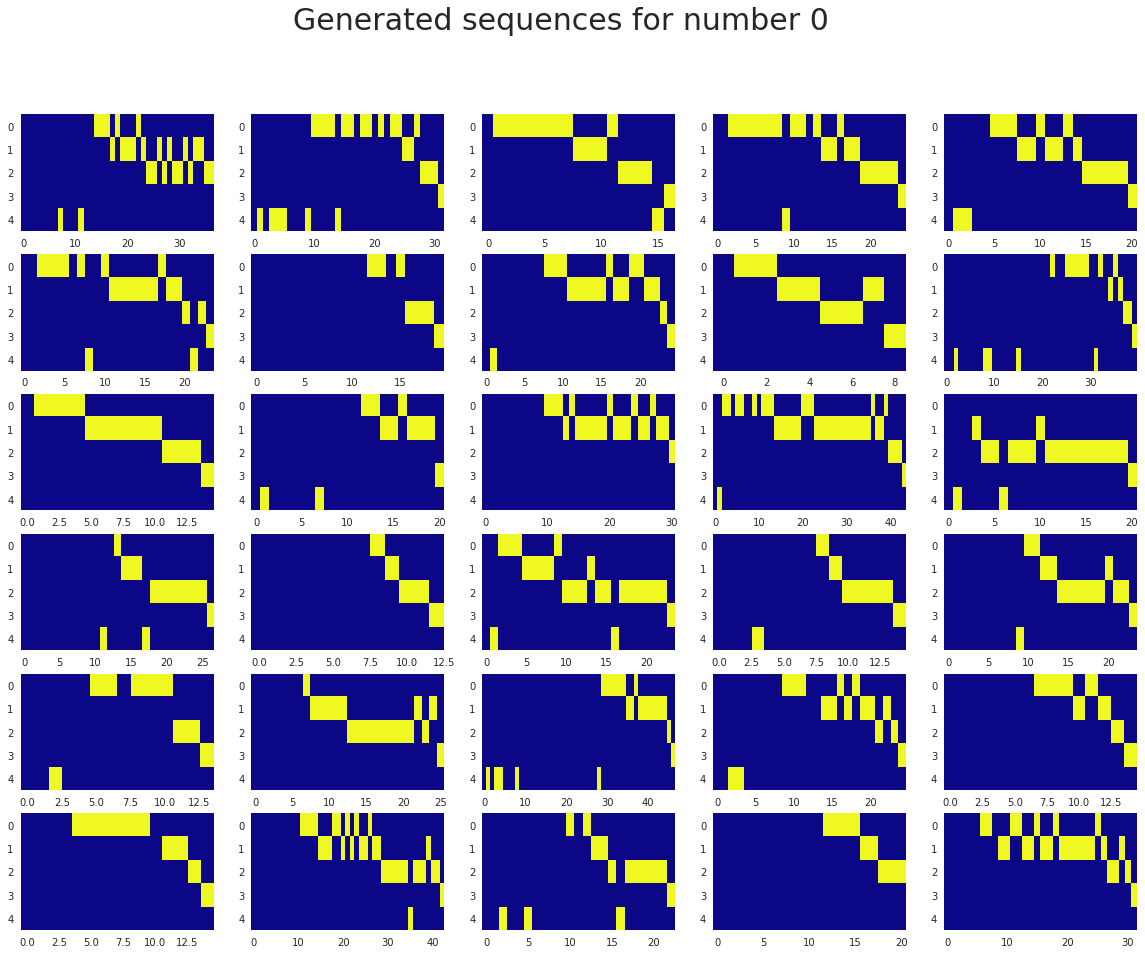

In [142]:
plt.figure(1, figsize=(20, 15))
plt.suptitle("Generated sequences for number 0", fontsize=30)
for index in range(1,31):
    state_seq, obs_seq = generate_state_seq_obs(A0, B0)
    image = np.stack([v[:,symbol-1] for symbol in obs_seq], axis=0).T
    plt.subplot(6,5,index)
    plt.grid(False)
    plt.imshow(image, interpolation='none', aspect='auto', cmap='plasma')

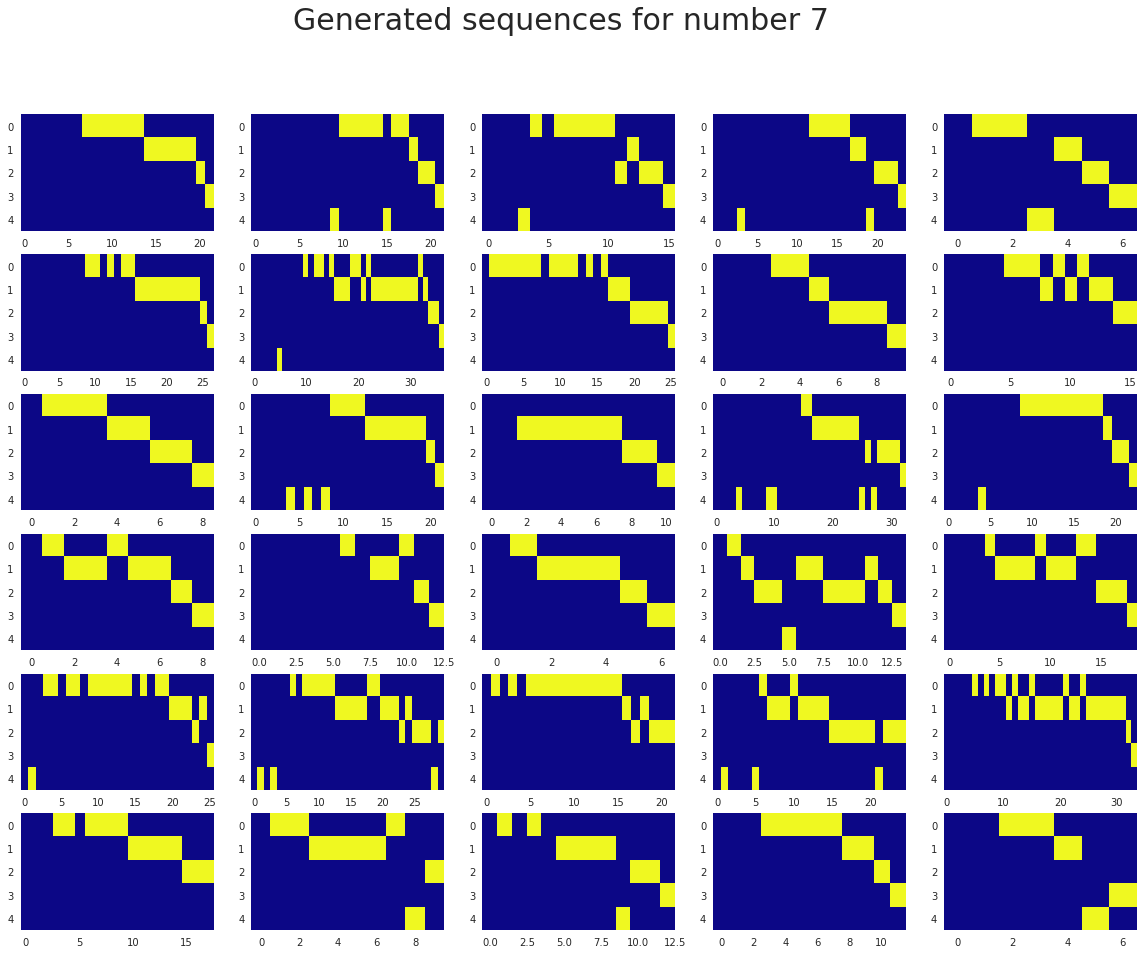

In [143]:
plt.figure(1, figsize=(20, 15))
plt.suptitle("Generated sequences for number 7", fontsize=30)
for index in range(1,31):
    state_seq, obs_seq = generate_state_seq_obs(A7, B7)
    image = np.stack([v[:,symbol-1] for symbol in obs_seq], axis=0).T
    plt.subplot(6,5,index)
    plt.grid(False)
    plt.imshow(image, interpolation='none', aspect='auto', cmap='plasma')

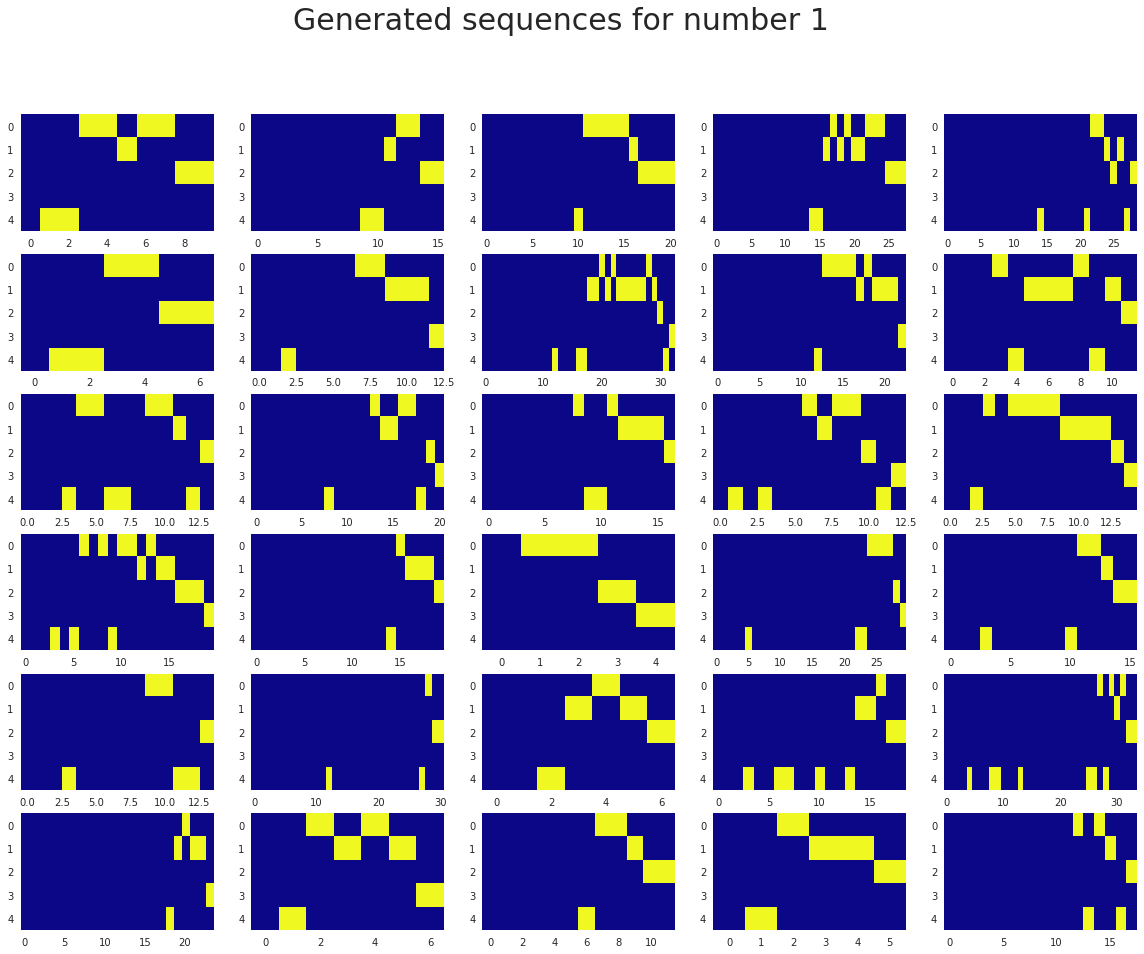

In [144]:
plt.figure(1, figsize=(20, 15))
plt.suptitle("Generated sequences for number 1", fontsize=30)
for index in range(1,31):
    state_seq, obs_seq = generate_state_seq_obs(A1, B1)
    image = np.stack([v[:,symbol-1] for symbol in obs_seq], axis=0).T
    plt.subplot(6,5,index)
    plt.grid(False)
    plt.imshow(image, interpolation='none', aspect='auto', cmap='plasma')

> Les résultat obtenu ne sont pas vraiment satisfaisants, il doit probablement y avoir une erreur dans mon code.